In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps
import pickle


from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt
from moge.network.omics_distance import *


# Import the TCGA cancer data

In [7]:
# import pickle
# with open('moge/data/luad_data_multi_U-T.pickle', 'wb') as file:
# #     luad_data = pickle.load(file)
#     pickle.dump(luad_data, file)

In [6]:
folder_path = "/data/datasets/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/data/datasets/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           import_sequences="multi", replace_U2T=True,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/clinical.py:36: FutureWarning: read_table is deprecated, use read_csv instead.
  na_values=["[Not Available]", "[Not Applicable]"],
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/clinical.py:61: FutureWarning: read_table is deprecated, use read_csv instead.
  usecols=ClinicalData.clinical_drug_colsname
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:30: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.data = self.preprocess_expression_table(pd.read_table(file_path), columns)
/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/

Unmatched lncRNAs 12727
Unmatched lncRNAs after gencode: 1033
Unmatched lncRNAs after lncBase: 812
Unmatched lncRNAs after HGNC: 758
Unmatched lncRNAs after lncipedia: 622


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:424: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  usecols=["Gene Name", "Transcript Name", "Transcript Type", "Location", "Strand"])
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:503: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  source_df = pd.read_table(self.noncode_source_path, header=None)
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:506: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  transcript2gene_df = pd.read_table(self.noncode_transcript2gene_path, header=None)
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:509: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  self.noncode_func_df = pd.read_table(self.noncode_func_path, header=None)
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.p

PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20157)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR
Processed genes info for  LNC


In [3]:
LNC = luad_data.LNC.get_genes_info()
MIR = luad_data.MIR.get_genes_info()
GE = luad_data.GE.get_genes_info()
print(GE.columns)
print(MIR.columns)
print(LNC.columns)

Index(['Transcript ID', 'Gene ID', 'Gene description', '3P-seq tags',
       'locus_type', 'location', 'gene_family', 'gene_family_id',
       'Transcript sequence', 'GO Terms', 'Disease association', 'Chromosome',
       'Chromosome arm', 'Chromosome region', 'Chromosome band',
       'Transcript length'],
      dtype='object')
Index(['miR family', 'Seed+m8', 'Mature sequence', 'Family Conservation?',
       'MiRBase Accession', 'MiRBase ID', 'location', 'ensembl_gene_id',
       'Disease association', 'locus_type', 'Transcript sequence',
       'Transcript length', 'Chromosome', 'Chromosome arm',
       'Chromosome region', 'Chromosome band', 'GO Terms', 'Rfams'],
      dtype='object')
Index(['Gene ID', 'Gene Name', 'HGNC Gene Name', 'Transcript id',
       'Transcript name', 'Transcript type', 'tag', 'Chromosome', 'start',
       'end', 'Strand', 'locus_type', 'Transcript sequence',
       'Disease association', 'GO Terms', 'Rfams'],
      dtype='object')


In [20]:
# node_list = GE[GE["gene_family"].notnull()].index[0:1000]
node_list = GE.index
# correlation_dist = compute_expression_correlation_dists(luad_data, modalities=["GE"],
#                                                         node_list=node_list, absolute_corr=True,
#                                                         squareform=False)
affinity = compute_annotation_affinities(GE, node_list=node_list,
                features=["location"], 
#                features=["Family", "tag", "Strand", "Chromosome"], 
#                                          correlation_dist=correlation_dist,
                                        nanmean=False, 
#                                          weights=[1, 1, 0.5, 0.5, 5],
                                        )


Gower's dissimilarity: Computing location , dtype: object , shape: (20157,)
['19q13.43', '10q11.23', '12p13.31', '12p13.31', '22q13.2']
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20157,)
['19', '10', '12', '12', '22']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing arm , dtype: object , shape: (20157,)
['q', 'q', 'p', 'p', 'q']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing region , dtype: object , shape: (20157,)
['13', '11', '13', '13', '13']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing band , dtype: object , shape: (20157,)
['43', '23', '31', '31', '2']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:166: RuntimeWarning: invalid value encountered in greater_equal
  
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:168: RuntimeWarning: Mean of empty slice
  


(203142246,)


/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:17: RuntimeWarning: divide by zero encountered in log10
  c = np.log10(np.power(degrees, k_power))
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/evaluation/utils.py:18: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(cosine_adj_hist_dist.pdf(np.power(degrees, k_power)))


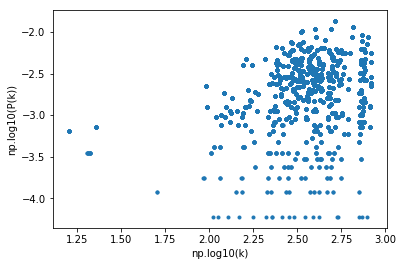

0.05761450686541157

In [34]:
from moge.evaluation.utils import get_scalefree_fit_score
from scipy.sparse import triu
from scipy.spatial.distance import squareform


affinities = squareform(affinity, checks=False)
print(affinities.shape)
adj_list = np.nansum(affinity, axis=1)
# adj_list = affinities[np.where(~np.isnan(affinities.data))].reshape((-1))

get_scalefree_fit_score(adj_list, plot=True)

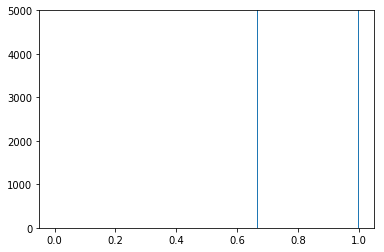

In [35]:
plt.hist(affinity[np.where(~np.isnan(affinity))].reshape((-1)), bins=500)
plt.ylim(top=5000)
plt.show()

In [23]:
threshold=0.70
print("threshold at", threshold,":",(affinity > threshold).sum())
# print("threshold at", threshold,":",(affinity < 0.01).sum())

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


threshold at 0.7 : 2735238


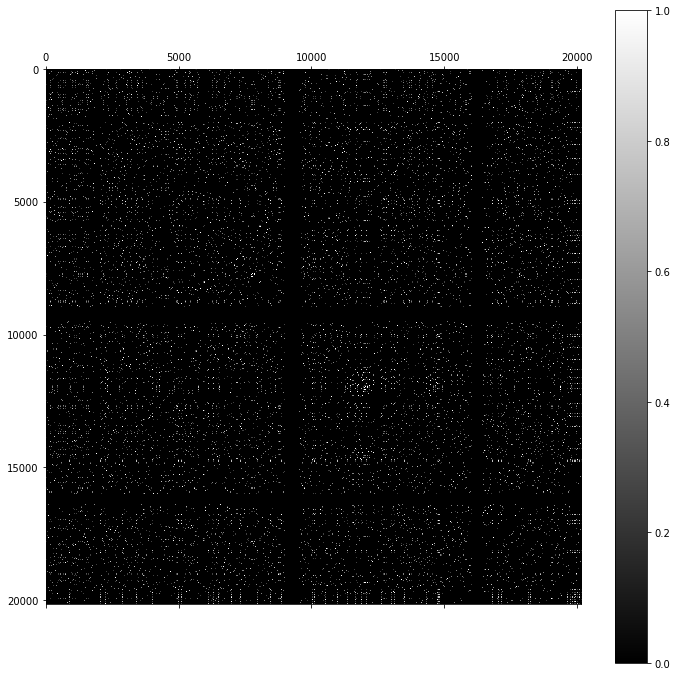

In [30]:
# matrix_heatmap(np.array(affinity>threshold, dtype=float))
matrix_heatmap(affinity)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


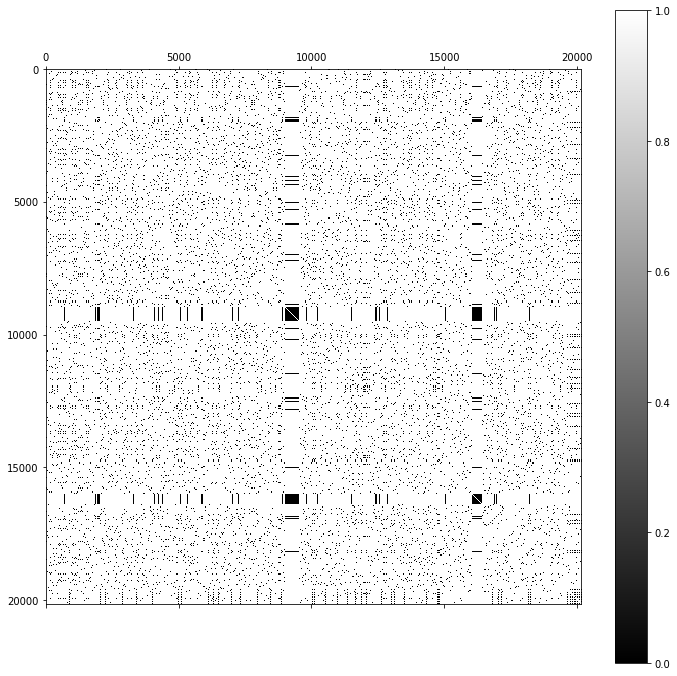

In [25]:
matrix_heatmap(np.array(affinity<0.01, dtype=float))

# Heterogeneous Network

In [2]:
import pickle
with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
    luad_data = pickle.load(file)
#     pickle.dump(luad_data, file)

In [3]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']
Number of nodes without seq removed: 1992
Total nodes (filtered): 32742


## Write node labels to file

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Attribute Affinity Positive Edges

In [37]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"], 
    compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
['GO:0002576|GO:0003674|GO:0005576|GO:0005615|GO:0008150|GO:0031093|GO:0034774|GO:0043312|GO:0062023|GO:0070062|GO:0072562|GO:1904813', 'GO:0003723|GO:0003727|GO:0005515|GO:0005654|GO:0005737|GO:0005783|GO:0006397|GO:0016554|GO:0016556|GO:0030895|GO:0050821|GO:0003725', 'GO:0001869|GO:0002020|GO:0002576|GO:0004867|GO:0005096|GO:0005102|GO:0005515|GO:0005576|GO:0005829|GO:0007597|GO:0010951|GO:0019838|GO:0019899|GO:0019959|GO:0019966|GO:0022617|GO:0031093|GO:0043120|GO:0043547|GO:0048306|GO:0048863|GO:0051056|GO:0062023|GO:0070062|GO:0072562', 'GO:0004867|GO:0005615|GO:0010951|GO:0030414|GO:0052548|GO:0070062', 'GO:0001576|GO:0006486|GO:0006688|GO:0007009|GO:0008378|GO:0015643|GO:0016020|GO:0030173|GO:0050512']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (20157,)
[nan, nan, "alzheimer's disease|colonic neoplasms|mental depression|depressive disorder|hepatolenticular degeneration|liver cirrhosis|liver cirrhosis, experimental|lung diseases|lung neoplasms|nephrotic syndrome|hepatocellular adenoma|liver carcinoma|acute kidney injury", 'noonan syndrome|otitis media', 'burkitt lymphoma|blood group antigen abnormality']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


59821 undirected positive edges (type='u') added.
299105 undirected negative edges (type='u_n') added.


In [38]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
    similarity_threshold=0.85, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=False,
    features=["locus_type", "gene_family_id", "location"], 
    weights=[1, 3, 1],
    compute_correlation=False)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (20157,)
['protein_coding', 'protein_coding', 'processed_transcript', 'nonsense_mediated_decay', 'processed_transcript']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing gene_family_id , dtype: object , shape: (20157,)
['594', '725', '1234', '1234', '442|454']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing location , dtype: object , shape: (20157,)
['19q13.43', '10q11.23', '12p13.31', '12p13.31', '22q13.2']
Location split to Chromosome, arm, region
Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (20157,)
['19', '10', '12', '12', '22']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing arm , dtype: object , shape: (20157,)
['q', 'q', 'p', 'p', 'q']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing region , dtype: object , shape: (20157,)
['13', '11', '13', '13', '13']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing band , dtype: object , shape: (20157,)
['43', '23', '31', '31', '2']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:166: RuntimeWarning: invalid value encountered in greater_equal
  
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:168: RuntimeWarning: Mean of empty slice
  


23598 undirected positive edges (type='u') added.
117990 undirected negative edges (type='u_n') added.


In [39]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Disease association"], 
    compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (1870,)
['GO:0035068|GO:0035195', nan, 'GO:0035068|GO:0035195', nan, nan]
Dice distance
Gower's dissimilarity: Computing Disease association , dtype: object , shape: (1870,)
["colonic neoplasms|heart failure|lung neoplasms|lung neoplasms|lung neoplasms|lung neoplasms|lung neoplasms|lung neoplasms|lung neoplasms|neoplasms|neoplasms|neoplasms|neoplasms|acth-secreting pituitary adenoma|neoplasms|neoplasms|digestive system neoplasms|head and neck neoplasms|hodgkin disease|neoplasms|sarcoma, kaposi|lung neoplasms|lupus vulgaris|melanoma|pancreatic neoplasms|pituitary neoplasms|salivary gland neoplasms|lymphoma, primary effusion|adrenocortical carcinoma|neoplasms|neoplasms|carcinoma, hepatocellular|lung neoplasms|neoplasms|retinoblastoma|adenocarcinoma|asthma|carcinoma|carcinoma|carcinoma, hepatocellular|leukemia, myeloid, acute|neoplasms|ovarian neoplasms|spinal cord injuries|spinal cord injuries|prostatic neoplasms|hypertro

/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


701 undirected positive edges (type='u') added.
3505 undirected negative edges (type='u_n') added.


In [40]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["Family", "Rfams"], 
    compute_correlation=False)

Gower's dissimilarity: Computing Family , dtype: object , shape: (1870,)
[nan, 'let-7a-2-3p/let-7g-3p', nan, 'let-7-5p/98-5p', 'let-7-5p/98-5p']
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Rfams , dtype: object , shape: (1870,)
['Rfam:RF00027', nan, 'Rfam:RF00027', nan, nan]
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


683 undirected positive edges (type='u') added.
3415 undirected negative edges (type='u_n') added.


In [90]:
edges = network.G.edges(nbunch=network.nodes["LNC"])
# network.G.remove_edges_from(set(edges))
len(edges)

438917

In [89]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.90, dissimilarity_threshold=0.1,
    negative_sampling_ratio=5.0, 
    nanmean=False,
    features=["locus_type", "Transcript type", "tag", "Strand", "Chromosome", "start", "end", "Transcript sequence"],
    weights=[0.5, 0.5, 1, 1, 0.5, 0.2, 0.2, 1],
    compute_correlation=False)

Gower's dissimilarity: Computing locus_type , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Transcript type , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing tag , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Strand , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Chromosome , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing start , dtype: float64 , shape: (12706,)
Euclidean distance (normalized ptp)
Gower's dissimilarity: Computing end , dtype: float64 , shape: (12706,)
Euclidean distance (normalized ptp)
1 undirected positive edges (type='u') added.
350980 undirected negative edges (type='u_n') added.


In [87]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
    similarity_threshold=0.70, dissimilarity_threshold=0.01,
    negative_sampling_ratio=5.0, nanmean=True,
    features=["GO Terms", "Family", "Disease association"], 
    compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Family , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (12706,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


463 undirected positive edges (type='u') added.
2315 undirected negative edges (type='u_n') added.


edge_list 416907 [('A1BG', 'DNAJA3', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('A1BG', 'NABP1', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('A1BG', 'BBS4', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('A1BG', 'ATOX1', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('A1BG', 'CHCHD6', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16})]


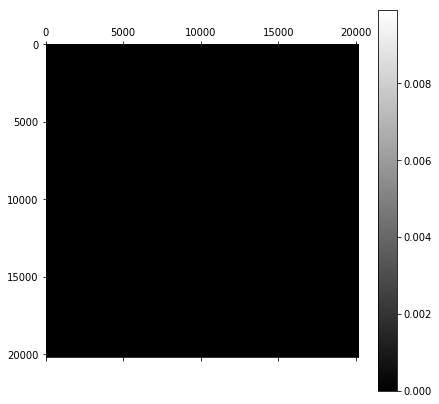

In [19]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

edge_list 6953 [('hsa-let-7a-1', 'hsa-mir-6882', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('hsa-let-7a-1', 'hsa-mir-4490', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('hsa-let-7a-1', 'hsa-mir-4646', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('hsa-let-7a-1', 'hsa-mir-5011', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('hsa-let-7a-1', 'hsa-mir-6742', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16})]


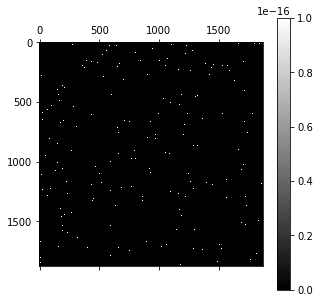

In [18]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.nodes["MIR"]).todense(),
              figsize=(5,5))

edge_list 368264 [('ENSG00000005206', 'LINC00629', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('ENSG00000031544', 'PTPRG-AS1', {'type': 'u_n', 'tag': 'affinity', 'weight': 1e-16}), ('AC000061.1', 'AC103831.1', {'type': 'u_n', 'tag': 'affinity', 'weight': 0.07564933532328243}), ('AC000061.1', 'AC010768.4', {'type': 'u_n', 'tag': 'affinity', 'weight': 0.0724215115881248}), ('AC000061.1', 'AP003469.1', {'type': 'u_n', 'tag': 'affinity', 'weight': 0.09577535725337015})]


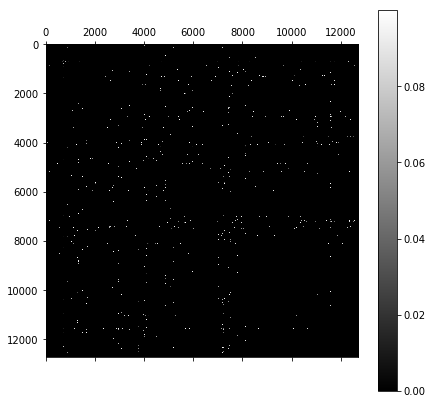

In [21]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.nodes["LNC"]).todense(),
              figsize=(7,7))

In [4]:
# IMPORT Affinity Edgelist
network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_NoExpression_affinity.edgelist", 
    file="moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
    is_directed=False)

In [92]:
# WRITE Affinity Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"]), 
#                   "moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#                   data=True)

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [11]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

Number of negative sampled edges between ['GE', 'MIR'] added: 10000
Number of negative sampled edges between ['GE', 'LNC'] added: 20000
Number of negative sampled edges between ['LNC', 'MIR'] added: 10000


# miRTarBase

In [4]:
mirtarbase_new = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True, data=False)
mirtarbase_old = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False, data=False)
mirtarbase_diff = list(set(mirtarbase_new) - set(mirtarbase_old))
len(mirtarbase_diff)

64749

In [5]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=mirtarbase_diff, #luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20,
                                        database="miRTarBase")

Adding edgelist with 1746 total unique MIR genes (source), but only matching 1615 nodes
Adding edgelist with 4740 total unique GE genes (target), but only matching 4616 nodes
64749 edges added.


# StarBase mRNA-RNA

In [13]:
starbase_new = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=1, data=False)
starbase_old = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=2, data=False)
starbase_diff = list(set(starbase_new) - set(starbase_old))
len(starbase_diff)

1516287

In [8]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_RNA_interactions(),
                                        modalities=["LNC", "GE"], correlation_weights=False, threshold=0.2,
                                        database="starBase")

Adding edgelist with 359 total unique LNC genes (source), but only matching 295 nodes
Adding edgelist with 10016 total unique GE genes (target), but only matching 6470 nodes
20600 edges added.


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:301: FutureWarning: read_table is deprecated, use read_csv instead.
  "pairGeneType", "interactionNum", 'expNum', "FreeEnergy"])


# BioGRID

In [6]:
biogrid_new = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, 
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.5.169.tab2.txt')
biogrid_old = luad_data.GE.get_BioGRID_GRN_edgelist(data=False, 
                biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt')
biogrid_diff = list(set(biogrid_new) - set(biogrid_old))
len(biogrid_diff)

/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:769: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  low_memory=True)
/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


33522

In [8]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=biogrid_diff, # luad_data.GE.get_BioGRID_GRN_edgelist(biogrid_interactions_file_path='/data/datasets/Bioinformatics_ExternalData/BioGRID/BIOGRID-ALL-3.4.162.tab2.txt'),
                                        modalities=["GE", "GE"], correlation_weights=False, threshold=0.2,
                                        database="BioGRID")

Adding edgelist with 2238 total unique GE genes (source), but only matching 2183 nodes
Adding edgelist with 7736 total unique GE genes (target), but only matching 7278 nodes
33522 edges added.


# NPInter

In [4]:
npinter_new = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=True, data=False)
npinter_old = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False, data=False)
npinter_diff = list(set(npinter_new) - set(npinter_old))
len(npinter_diff)

123486

In [11]:
network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False),
                                         modalities=["LNC", "LNC"], correlation_weights=False, threshold=0.20,
                                        database="NPInter")

Adding edgelist with 727 total unique LNC genes (source), but only matching 12 nodes
Adding edgelist with 5659 total unique LNC genes (target), but only matching 4 nodes
85335 edges added.


In [4]:
import pandas as pd
df = pd.read_table(luad_data.LNC.NPInter_interactions_file_path)
df

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  
/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,interID,ncID,ncType,ncIdentifier,ncName,PartnerID,prType,prIdentifier,InteractionPartner,interDescription,experiment,PubMedID,organism,tag,interClass,interLevel
0,ncRI-3000001,127667,NONCODE,NONOTHNOBEDT000074,4.5S,135149,UniProt,P0A6M8,fusA,"Following translocation, 4.5S RNA replaces 23S...",EMSA,8662727,Escherichia coli,ncRNA-protein binding,binding,RNA-Protein
1,ncRI-3000002,127667,NONCODE,NONOTHNOBEDT000074,4.5S,135166,UniProt,P0AGD7,ffh,The 4.5S RNA is associated in vivo with P48. 4...,Immunoprecipitation experiments,1281314,Escherichia coli,ncRNA-protein binding,binding,RNA-Protein
2,ncRI-3000003,127670,NONCODE,NONOTHNOBEDT000078,6S,134921,UniProt,M1FYN7,rpoB,UV crosslinking experiments revealed that 6S R...,cross-linking,10892648,Escherichia coli,ncRNA-protein binding,binding,RNA-Protein
3,ncRI-3000004,127670,NONCODE,NONOTHNOBEDT000078,6S,135092,UniProt,P00579,rpoD,The stable association of sigma70 with core en...,cross-linking,10892648,Escherichia coli,ncRNA-protein binding,binding,RNA-Protein
4,ncRI-3000005,127670,NONCODE,NONOTHNOBEDT000078,6S,135154,UniProt,P0A8T7,rpoC,UV crosslinking experiments revealed that 6S R...,cross-linking,10892648,Escherichia coli,ncRNA-protein binding,binding,RNA-Protein
5,ncRI-3000006,60587,NONCODE,NONHSAG040596,7SK,130918,RefSeq,NM_002467,MYC,Electrophoretic mobility shift experiment indi...,EMSA,9018369,Homo sapiens,regulatory;promoter as action site,regulatory,RNA-RNA
6,ncRI-3000007,60587,NONCODE,NONHSAG040596,7SK,131364,RefSeq,NM_020469,ABO,Promoters pU6 and p7SK proved to express high ...,NaN,22522162,Homo sapiens,regulatory,regulatory,RNA-RNA
7,ncRI-3000008,60587,NONCODE,NONHSAG040596,7SK,135074,UniProt,O94992,HEXIM1,Binding of the 7SK snRNA turns the HEXIM1 prot...,NaN,15201869,Homo sapiens,ncRNA-protein binding,binding,RNA-Protein
8,ncRI-3000009,60587,NONCODE,NONHSAG040596,7SK,135074,UniProt,O94992,HEXIM1,"When associated with 7SK small nuclear RNA, HE...",NaN,17671421,Homo sapiens,ncRNA-protein binding,binding,RNA-Protein
9,ncRI-3000010,60587,NONCODE,NONHSAG040596,7SK,135074,UniProt,O94992,HEXIM1,HEXIM1 suppresses transcription elongation via...,NaN,18407829,Homo sapiens,ncRNA-protein binding,binding,RNA-Protein


In [17]:
df["interLevel"].value_counts()

RNA-Protein    335026
RNA-RNA        152521
RNA-DNA          3822
DNA-TF             36
DNA-DNA             9
DNA-Protein         2
Name: interLevel, dtype: int64

# lncBase

In [9]:
from moge.network.heterogeneous_network import get_rename_dict
lncbase_rename_dict = get_rename_dict(luad_data.LNC.get_genes_info(), "Gene ID")

In [10]:
lncbase_new = luad_data.LNC.get_lncBase_miRNA_lncRNA_predicted_interactions_edgelist(rename_dict=lncbase_rename_dict,
                                                                                     data=False)
lncbase_old = luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict, 
                                                                           data=False)
lncbase_diff = list(set(lncbase_new) - set(lncbase_old))
print(len(lncbase_diff))

/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:339: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  lncbase_df = pd.read_table(self.lncBase_interactions_file_path)


337031


In [11]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
#                                          modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20,
#                                         database="lncRNome")

network.add_directed_edges_from_edgelist(edgelist=lncbase_diff, #luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(rename_dict=lncbase_rename_dict),
                                         modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20,
                                        database="lncBase")


network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="LncReg")

Adding edgelist with 1746 total unique MIR genes (source), but only matching 1615 nodes
Adding edgelist with 20412 total unique LNC genes (target), but only matching 11692 nodes
337031 edges added.
Adding edgelist with 137 total unique LNC genes (source), but only matching 22 nodes
Adding edgelist with 373 total unique GE genes (target), but only matching 172 nodes
554 edges added.


# lncrna2target

In [12]:
lnc2tar_low = luad_data.LNC.get_lncrna2target_low_throughput_interactions(data=False)
lnc2tar_high = luad_data.LNC.get_lncrna2target_high_throughput_interactions(data=False)
lnc2tar_diff = list(set(lnc2tar_low) - set(lnc2tar_high))
len(lnc2tar_diff)

/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:447: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(self.lncrna2target_high_throughput_table_path, low_memory=True)
/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


1277

In [13]:
network.add_directed_edges_from_edgelist(edgelist=lnc2tar_diff, #luad_data.LNC.get_lncrna2target_high_throughput_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncrna2target")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_low_throughput_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncrna2target_low")

network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRInter_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncRInter")

Adding edgelist with 243 total unique LNC genes (source), but only matching 79 nodes
Adding edgelist with 677 total unique GE genes (target), but only matching 454 nodes
1277 edges added.


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:479: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  table = pd.read_table(self.lncRInter_table_path)
/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:487: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda x: x[:-1] + "-" + x[-1])


Adding edgelist with 170 total unique LNC genes (source), but only matching 83 nodes
Adding edgelist with 315 total unique GE genes (target), but only matching 252 nodes
522 edges added.


# Filter the edges

In [35]:
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.train.pickle', 'rb') as file:
    network = pickle.load(file)

In [36]:
edges_bunch = [(u,v,d) for u,v,d in network.G.edges(data=True) if ("database" in d and 
                                                                   d["database"]=="miRTarBase")]
print(len(edges_bunch))

319246


In [37]:
database_nodes = nx.DiGraph(incoming_graph_data=edges_bunch).nodes()
database_nodes = list(database_nodes)
len(database_nodes)

16695

In [38]:
edges_bunch = [(u,v,d) for u,v,d in network.G.edges(nbunch=database_nodes, data=True) \
               if d["type"] == 'u' or d["type"] == "u_n" or ("database" in d and d["database"]=="miRTarBase")]
print(len(edges_bunch))

664279


In [39]:
network.G.clear()
network.G.add_edges_from(edges_bunch)

# Filter the node_list

In [15]:
isolates = list(nx.isolates(network.G))
len(isolates)

11308

In [16]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node not in isolates and node in network.G.nodes()]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node not in isolates and node in network.G.nodes()]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node not in isolates and node in network.G.nodes()]
network.node_list = [node for node in network.node_list if node not in isolates and node in network.G.nodes()]

In [31]:
# network.remove_extra_nodes() # Also makes network unmutable

In [17]:
network.G.number_of_nodes()

44670

In [18]:
len(network.node_list)

22648

In [20]:
# WRITE/READ FULL network
import pickle
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_biogrid_starbase_lncrna2target_lncrinter.test.pickle', 
          'wb') as file:
    pickle.dump(network, file)
#     network = pickle.load(file)

In [28]:
len(network.get_edgelist(edge_types="d", node_list=network.node_list))

55891

# Split train-test by edges

In [45]:
import pickle
# WRITE READ network
with open('moge/data/LMN_future_recall/Predict/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'rb') as file:
    network = pickle.load(file)

In [27]:
from moge.evaluation.utils import split_train_test_edges

network_train, test_edges, val_edges = split_train_test_edges(network, network.node_list, 
#                                                                            databases=,
                                                          test_frac=.00, val_frac=.20, edge_types=["d"], 
                                                          seed=0, verbose=True)

preprocessing...
edges_to_remove 345875
edges_to_remove (after MST) 345875
test_edges_size 0
val_edges_size 69175
Removed 0 test, and 69175 val, type ['d'] edges


In [28]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581
MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


# Split train-test by nodes

In [ ]:
from moge.evaluation.utils import split_train_test_nodes

network_train, test_edges, val_edges, test_nodes, val_nodes = split_train_test_nodes(network, network.nodes["LNC"],
                                                          test_frac=.00, val_frac=.10, edge_types=["d"], 
                                                          seed=0, verbose=True)

In [ ]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.val_node_list = test_nodes
network_val.val_node_list = val_nodes
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)
len(network_test.node_list), len(network_val.node_list)

In [ ]:
network_train.G.number_of_edges()

# Write train-test-val split as separate networks

In [29]:
# WRITE
import pickle
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

In [30]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.full.edgelist", 
                  data=False)

In [6]:
# Write edgelist interactions only
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.interactions.edgelist",
                  data=False)

In [11]:
# Write edgelist interactions only, database specific
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], 
                                                                    databases=["BioGRID"], 
                                                                    node_list=network.node_list)),
                  "moge/data/LMN_future_recall/TRAIN/Interactions_Only/GE/lmn_train.BioGRID.interactions.edgelist",
                  data=False)

## Network Info & Visualizations

In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

In [ ]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

In [ ]:
matrix_heatmap(csr_un.toarray())

In [ ]:
matrix_heatmap(csr_u.toarray())

In [ ]:
matrix_heatmap(csr_d.toarray())